from pymongo import MongoClient
import pandas as pd
from pprint import pprint
import json
from bson import ObjectId  


In [422]:
import pandas as pd
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from shapely.geometry import Point
import folium
import json

# Import DATA FROM MONGO

In [423]:
!mongoimport --host localhost --db mydatabase --collection mycollection --type csv --file /Users/owner/Library/CloudStorage/OneDrive-Personal/ProjectWEO/file.csv --headerline


2024-03-01T20:47:48.299-0500	connected to: mongodb://localhost/
2024-03-01T20:47:48.480-0500	930 document(s) imported successfully. 0 document(s) failed to import.


In [424]:
# Connect to MongoDB
client = MongoClient('localhost', 27017)  # Assuming MongoDB is running on localhost

# Select the database and collection
db = client['mydatabase']
collection = db['mycollection']


# Find all documents in the collection
cursor = collection.find({})


# Iterate over the documents and print them
for document in cursor:
    print(document)

{'_id': ObjectId('65dd09e4cc76e944a8bb2448'), 'Country Group': 'Emerging Africa', 'ISO': 'UGA', 'indicator code': 'PCPIPCH', 'Country': 'Uganda', 'Subject Descriptor': 'Inflation, average consumer prices', 'Units': 'Percent change', 'Scale': '', 'notes': 'See notes for:  Inflation, average consumer prices (Index).', '2019': 2, '2020': 3, '2021': 2, '2022': 7, 'FY': 2022.0}
{'_id': ObjectId('65dd09e4cc76e944a8bb2449'), 'Country Group': 'Emerging Latin America', 'ISO': 'TTO', 'indicator code': 'NID_NGDP', 'Country': 'Trinidad and Tobago', 'Subject Descriptor': 'Total investment', 'Units': 'Percent of GDP', 'Scale': '', 'notes': '', '2019': 0, '2020': 0, '2021': 0, '2022': 0, 'FY': ''}
{'_id': ObjectId('65dd09e4cc76e944a8bb244a'), 'Country Group': 'Emerging Africa', 'ISO': 'KEN', 'indicator code': 'PCPIPCH', 'Country': 'Kenya', 'Subject Descriptor': 'Inflation, average consumer prices', 'Units': 'Percent change', 'Scale': '', 'notes': 'See notes for:  Inflation, average consumer prices (I

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [425]:
# review the collections in our database

collections = db.list_collection_names()

collections

['mycollection']

In [426]:
# Get the first document from the cursor
first_document = collection.find_one()

# Extract column names from the first document
column_names = list(first_document.keys())

# Print column names
print(column_names)

['_id', 'Country Group', 'ISO', 'indicator code', 'Country', 'Subject Descriptor', 'Units', 'Scale', 'notes', '2019', '2020', '2021', '2022', 'FY']


In [427]:
# Get all documents from the collection
cursor = collection.find({})

# Convert documents to a list of dictionaries
documents_list = list(cursor)

# Convert list of dictionaries to a DataFrame
df = pd.DataFrame(documents_list)

# Print the DataFrame
df

,_id,Country Group,ISO,indicator code,Country,Subject Descriptor,Units,Scale,notes,2019,2020,2021,2022,FY
0,65dd09e4cc76e944a8bb2448,Emerging Africa,UGA,PCPIPCH,Uganda,"Inflation, average consumer prices",Percent change,,"See notes for: Inflation, average consumer pr...",2,3,2,7,2022.0
1,65dd09e4cc76e944a8bb2449,Emerging Latin America,TTO,NID_NGDP,Trinidad and Tobago,Total investment,Percent of GDP,,,0,0,0,0,
2,65dd09e4cc76e944a8bb244a,Emerging Africa,KEN,PCPIPCH,Kenya,"Inflation, average consumer prices",Percent change,,"See notes for: Inflation, average consumer pr...",5,5,6,8,2022.0
3,65dd09e4cc76e944a8bb244b,Emerging Middle East,IRQ,NID_NGDP,Iraq,Total investment,Percent of GDP,,,0,0,0,0,
4,65dd09e4cc76e944a8bb244c,Emerging Africa,MOZ,PCPIPCH,Mozambique,"Inflation, average consumer prices",Percent change,,"See notes for: Inflation, average consumer pr...",3,3,6,10,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13015,65e28544605ab545d0f9eff6,Emerging Asia,VNM,NGDPD,Vietnam,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",332,346,370,406,2022.0
13016,65e28544605ab545d0f9eff7,Emerging Asia,VNM,PPPEX,Vietnam,Implied PPP conversion rate,National currency per current international do...,,"See notes for: Gross domestic product, curren...",7530,7542,7418,7200,2022.0
13017,65e28544605ab545d0f9eff8,Emerging Asia,VNM,NID_NGDP,Vietnam,Total investment,Percent of GDP,,Source: National Statistics Office. Country au...,32,32,33,33,2022.0
13018,65e28544605ab545d0f9eff9,Emerging Asia,VNM,PCPIPCH,Vietnam,"Inflation, average consumer prices",Percent change,,"See notes for: Inflation, average consumer pr...",3,3,2,3,2022.0


# MERGE THE COORDINATES of COUNTRIES IN ONE FILE

In [428]:
# Load the two CSV files into DataFrames
df = pd.read_csv('/Users/owner/Library/CloudStorage/OneDrive-Personal/ProjectWEO/file.csv')
df2 = pd.read_csv('/Users/owner/Library/CloudStorage/OneDrive-Personal/ProjectWEO/countries.csv')

# Merge the DataFrames based on a common column
merged_df = pd.merge(df, df2, on='Country')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv('merged_file.csv', index=False)

merged_df.to_csv('/Users/owner/Library/CloudStorage/OneDrive-Personal/ProjectWEO/merged_file.csv', index=False)


merged_df

,Country Group,ISO,indicator code,Country,Subject Descriptor,Units,Scale,notes,2019,2020,2021,2022,FY,latitude,longitude
0,Emerging Latin America,TTO,NID_NGDP,Trinidad and Tobago,Total investment,Percent of GDP,NaN,NaN,0,0,0,0,NaN,10.691803,-61.222503
1,Emerging Latin America,TTO,NGDP,Trinidad and Tobago,"Gross domestic product, current prices",National currency,Billions,Source: National Statistics Office Latest actu...,156,136,162,203,2022.0,10.691803,-61.222503
2,Emerging Latin America,TTO,NGDPD,Trinidad and Tobago,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",23,20,24,30,2022.0,10.691803,-61.222503
3,Emerging Latin America,TTO,PPPEX,Trinidad and Tobago,Implied PPP conversion rate,National currency per current international do...,NaN,"See notes for: Gross domestic product, curren...",4,4,4,5,2022.0,10.691803,-61.222503
4,Emerging Latin America,TTO,PCPIPCH,Trinidad and Tobago,"Inflation, average consumer prices",Percent change,NaN,"See notes for: Inflation, average consumer pr...",1,1,2,6,2022.0,10.691803,-61.222503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,Emerging Asia,VNM,NGDPD,Vietnam,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",332,346,370,406,2022.0,14.058324,108.277199
806,Emerging Asia,VNM,PPPEX,Vietnam,Implied PPP conversion rate,National currency per current international do...,NaN,"See notes for: Gross domestic product, curren...",7530,7542,7418,7200,2022.0,14.058324,108.277199
807,Emerging Asia,VNM,NID_NGDP,Vietnam,Total investment,Percent of GDP,NaN,Source: National Statistics Office. Country au...,32,32,33,33,2022.0,14.058324,108.277199
808,Emerging Asia,VNM,PCPIPCH,Vietnam,"Inflation, average consumer prices",Percent change,NaN,"See notes for: Inflation, average consumer pr...",3,3,2,3,2022.0,14.058324,108.277199


# DATA ETL (GENERAL)

In [429]:
# include the list of the columns first
columns = merged_df.columns.tolist()

# identify the index column
country_index = columns.index("Country")

# move the column in the order needed
columns.insert(1, columns.pop(country_index))

# reindex the DataFrame with the new column order
Clean_df = merged_df.reindex(columns=columns)

# confirm by displaying the data 
Clean_df.head()

,Country Group,Country,ISO,indicator code,Subject Descriptor,Units,Scale,notes,2019,2020,2021,2022,FY,latitude,longitude
0,Emerging Latin America,Trinidad and Tobago,TTO,NID_NGDP,Total investment,Percent of GDP,NaN,NaN,0,0,0,0,NaN,10.691803,-61.222503
1,Emerging Latin America,Trinidad and Tobago,TTO,NGDP,"Gross domestic product, current prices",National currency,Billions,Source: National Statistics Office Latest actu...,156,136,162,203,2022.0,10.691803,-61.222503
2,Emerging Latin America,Trinidad and Tobago,TTO,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",23,20,24,30,2022.0,10.691803,-61.222503
3,Emerging Latin America,Trinidad and Tobago,TTO,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,"See notes for: Gross domestic product, curren...",4,4,4,5,2022.0,10.691803,-61.222503
4,Emerging Latin America,Trinidad and Tobago,TTO,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,"See notes for: Inflation, average consumer pr...",1,1,2,6,2022.0,10.691803,-61.222503


In [430]:
# Drop the '_id' and 'notes' columns
columns_to_drop = ['notes']
Final_df = Clean_df.drop(columns=columns_to_drop)

# Print the DataFrame
Final_df

,Country Group,Country,ISO,indicator code,Subject Descriptor,Units,Scale,2019,2020,2021,2022,FY,latitude,longitude
0,Emerging Latin America,Trinidad and Tobago,TTO,NID_NGDP,Total investment,Percent of GDP,NaN,0,0,0,0,NaN,10.691803,-61.222503
1,Emerging Latin America,Trinidad and Tobago,TTO,NGDP,"Gross domestic product, current prices",National currency,Billions,156,136,162,203,2022.0,10.691803,-61.222503
2,Emerging Latin America,Trinidad and Tobago,TTO,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,23,20,24,30,2022.0,10.691803,-61.222503
3,Emerging Latin America,Trinidad and Tobago,TTO,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,4,4,4,5,2022.0,10.691803,-61.222503
4,Emerging Latin America,Trinidad and Tobago,TTO,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,1,1,2,6,2022.0,10.691803,-61.222503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,Emerging Asia,Vietnam,VNM,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,332,346,370,406,2022.0,14.058324,108.277199
806,Emerging Asia,Vietnam,VNM,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,7530,7542,7418,7200,2022.0,14.058324,108.277199
807,Emerging Asia,Vietnam,VNM,NID_NGDP,Total investment,Percent of GDP,NaN,32,32,33,33,2022.0,14.058324,108.277199
808,Emerging Asia,Vietnam,VNM,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,3,3,2,3,2022.0,14.058324,108.277199


In [431]:
# Convert 'FY' column to string and extract year
Final_df['FY'] = Final_df['FY'].astype(str).str[:4]

# Print the DataFrame
Final_df

,Country Group,Country,ISO,indicator code,Subject Descriptor,Units,Scale,2019,2020,2021,2022,FY,latitude,longitude
0,Emerging Latin America,Trinidad and Tobago,TTO,NID_NGDP,Total investment,Percent of GDP,NaN,0,0,0,0,nan,10.691803,-61.222503
1,Emerging Latin America,Trinidad and Tobago,TTO,NGDP,"Gross domestic product, current prices",National currency,Billions,156,136,162,203,2022,10.691803,-61.222503
2,Emerging Latin America,Trinidad and Tobago,TTO,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,23,20,24,30,2022,10.691803,-61.222503
3,Emerging Latin America,Trinidad and Tobago,TTO,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,4,4,4,5,2022,10.691803,-61.222503
4,Emerging Latin America,Trinidad and Tobago,TTO,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,1,1,2,6,2022,10.691803,-61.222503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,Emerging Asia,Vietnam,VNM,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,332,346,370,406,2022,14.058324,108.277199
806,Emerging Asia,Vietnam,VNM,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,7530,7542,7418,7200,2022,14.058324,108.277199
807,Emerging Asia,Vietnam,VNM,NID_NGDP,Total investment,Percent of GDP,NaN,32,32,33,33,2022,14.058324,108.277199
808,Emerging Asia,Vietnam,VNM,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,3,3,2,3,2022,14.058324,108.277199


In [432]:
Final_df.columns

Index(['Country Group', 'Country', 'ISO', 'indicator code',
       'Subject Descriptor', 'Units', 'Scale', '2019', '2020', '2021', '2022',
       'FY', 'latitude', 'longitude'],
      dtype='object')

# CREATE DATAFRAME by COUNTRY GROUPS

In [449]:
# Filter DataFrame for specified country group
emergingafrica_df = Final_df[Final_df['Country Group'].str.strip(" ") == "Emerging Africa"]
# Print the result
emergingafrica_df

,Country Group,Country,ISO,indicator code,Subject Descriptor,Units,Scale,2019,2020,2021,2022,FY,latitude,longitude
6,Emerging Africa,Kenya,KEN,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,5,5,6,8,2022,-0.023559,37.906193
7,Emerging Africa,Kenya,KEN,NGDPPC,"Gross domestic product per capita, current prices",National currency,Units,215078,219563,241778,263988,2019,-0.023559,37.906193
8,Emerging Africa,Kenya,KEN,NGDPDPC,"Gross domestic product per capita, current prices",U.S. dollars,Units,2108,2068,2209,2245,2019,-0.023559,37.906193
9,Emerging Africa,Kenya,KEN,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,42,43,43,43,2022,-0.023559,37.906193
10,Emerging Africa,Kenya,KEN,NID_NGDP,Total investment,Percent of GDP,NaN,19,20,20,19,2022,-0.023559,37.906193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,Emerging Africa,Zambia,ZMB,NGDPDPC,"Gross domestic product per capita, current prices",U.S. dollars,Units,1268,957,1137,1486,2019,-13.133897,27.849332
278,Emerging Africa,Zambia,ZMB,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,5,5,6,6,2021,-13.133897,27.849332
279,Emerging Africa,Zambia,ZMB,NID_NGDP,Total investment,Percent of GDP,NaN,39,32,28,32,2021,-13.133897,27.849332
280,Emerging Africa,Zambia,ZMB,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,9,16,22,11,2021,-13.133897,27.849332


In [434]:
# Filter DataFrame for specified country group
emerginglatin_df = Final_df[Final_df['Country Group'] == "Emerging Latin America"]

# Print the result
emerginglatin_df

,Country Group,Country,ISO,indicator code,Subject Descriptor,Units,Scale,2019,2020,2021,2022,FY,latitude,longitude
0,Emerging Latin America,Trinidad and Tobago,TTO,NID_NGDP,Total investment,Percent of GDP,NaN,0,0,0,0,nan,10.691803,-61.222503
1,Emerging Latin America,Trinidad and Tobago,TTO,NGDP,"Gross domestic product, current prices",National currency,Billions,156,136,162,203,2022,10.691803,-61.222503
2,Emerging Latin America,Trinidad and Tobago,TTO,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,23,20,24,30,2022,10.691803,-61.222503
3,Emerging Latin America,Trinidad and Tobago,TTO,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,4,4,4,5,2022,10.691803,-61.222503
4,Emerging Latin America,Trinidad and Tobago,TTO,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,1,1,2,6,2022,10.691803,-61.222503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523,Emerging Latin America,Venezuela,VEN,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,73,44,58,92,2018,6.423750,-66.589730
524,Emerging Latin America,Venezuela,VEN,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,0,0,1,3,2018,6.423750,-66.589730
525,Emerging Latin America,Venezuela,VEN,NID_NGDP,Total investment,Percent of GDP,NaN,0,0,0,0,2018,6.423750,-66.589730
526,Emerging Latin America,Venezuela,VEN,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,19906,2355,1589,187,2022,6.423750,-66.589730


In [435]:
# Filter DataFrame for specified country group
emergingME_df = Final_df[Final_df['Country Group'] == "Emerging Middle East"]

# Print the result
emergingME_df

,Country Group,Country,ISO,indicator code,Subject Descriptor,Units,Scale,2019,2020,2021,2022,FY,latitude,longitude
48,Emerging Middle East,Iraq,IRQ,NID_NGDP,Total investment,Percent of GDP,NaN,0,0,0,0,nan,33.223191,43.679291
49,Emerging Middle East,Iraq,IRQ,NGDP,"Gross domestic product, current prices",National currency,Billions,274884,216015,299240,378653,2022,33.223191,43.679291
50,Emerging Middle East,Iraq,IRQ,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,233,181,206,261,2022,33.223191,43.679291
51,Emerging Middle East,Iraq,IRQ,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,590,520,679,750,2022,33.223191,43.679291
52,Emerging Middle East,Iraq,IRQ,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,0,1,6,5,2022,33.223191,43.679291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,Emerging Middle East,Uzbekistan,UZB,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,60,60,70,80,2022,41.377491,64.585262
686,Emerging Middle East,Uzbekistan,UZB,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,2056,2261,2457,2614,2022,41.377491,64.585262
687,Emerging Middle East,Uzbekistan,UZB,NID_NGDP,Total investment,Percent of GDP,NaN,40,38,40,38,2022,41.377491,64.585262
688,Emerging Middle East,Uzbekistan,UZB,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,15,13,11,11,2022,41.377491,64.585262


In [436]:
# Filter DataFrame for specified country group
emergingasia_df = Final_df[Final_df['Country Group'] == "Emerging Asia"]

# Print the result
emergingasia_df

,Country Group,Country,ISO,indicator code,Subject Descriptor,Units,Scale,2019,2020,2021,2022,FY,latitude,longitude
30,Emerging Asia,Bangladesh,BGD,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,5,6,6,6,2022,23.684994,90.356331
31,Emerging Asia,Bangladesh,BGD,NGDP,"Gross domestic product, current prices",National currency,Billions,29514,31705,35302,39717,2022,23.684994,90.356331
32,Emerging Asia,Bangladesh,BGD,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,351,374,416,460,2022,23.684994,90.356331
33,Emerging Asia,Bangladesh,BGD,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,31,32,32,31,2022,23.684994,90.356331
34,Emerging Asia,Bangladesh,BGD,NID_NGDP,Total investment,Percent of GDP,NaN,32,31,31,32,2022,23.684994,90.356331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,Emerging Asia,Vietnam,VNM,NGDPD,"Gross domestic product, current prices",U.S. dollars,Billions,332,346,370,406,2022,14.058324,108.277199
806,Emerging Asia,Vietnam,VNM,PPPEX,Implied PPP conversion rate,National currency per current international do...,NaN,7530,7542,7418,7200,2022,14.058324,108.277199
807,Emerging Asia,Vietnam,VNM,NID_NGDP,Total investment,Percent of GDP,NaN,32,32,33,33,2022,14.058324,108.277199
808,Emerging Asia,Vietnam,VNM,PCPIPCH,"Inflation, average consumer prices",Percent change,NaN,3,3,2,3,2022,14.058324,108.277199


# CLEAN DATA BY DROPPING COUNTRIES DUPLICATIONS ROWS AND CREATE PLOTLY MAP

In [452]:
# Drop duplicate countries
merged_emergingasia_df_unique = emergingasia_df.drop_duplicates(subset='Country')
merged_emergingME_df_unique = emergingME_df.drop_duplicates(subset='Country')
merged_emerginglatin_df_unique = emerginglatin_df.drop_duplicates(subset='Country')
merged_emergingafrica_df_unique = emergingafrica_df.drop_duplicates(subset='Country')



/var/folders/t4/w3vljbzj433_gszvl1s1gb7w0000gn/T/ipykernel_52489/3886778473.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

/var/folders/t4/w3vljbzj433_gszvl1s1gb7w0000gn/T/ipykernel_52489/3886778473.py:30: UserWarning:

Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


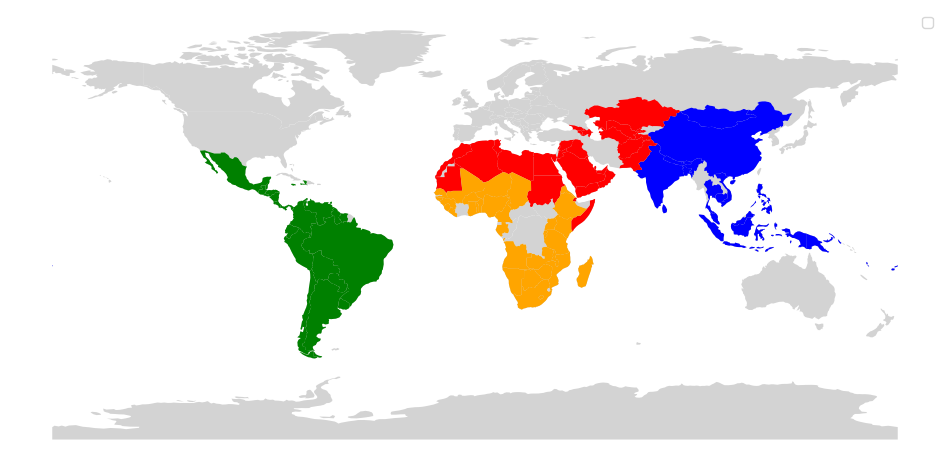

In [499]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Define colors for each group
color_emergingasia = 'blue'
color_emerginglatin = 'green'
color_emergingME = 'red'
color_emergingafrica = 'orange'

# Plot world map
fig, ax = plt.subplots(figsize=(12, 8))
world.plot(ax=ax, color='lightgrey')

# Plot Emerging Asia countries
world[world.name.isin(merged_emergingasia_df_unique['Country'])].plot(color=color_emergingasia, ax=ax, label='Emerging Asia')

# Plot Emerging Latin countries
world[world.name.isin(merged_emerginglatin_df_unique['Country'])].plot(color=color_emerginglatin, ax=ax, label='Emerging Latin')

# Plot Emerging ME countries
world[world.name.isin(merged_emergingME_df_unique['Country'])].plot(color=color_emergingME, ax=ax, label='Emerging ME')

# Plot Emerging Africa countries
world[world.name.isin(merged_emergingafrica_df_unique['Country'])].plot(color=color_emergingafrica, ax=ax, label='Emerging Africa')

ax.set_axis_off()  # Turn off axis
ax.legend()  # Show legend

plt.show()


In [455]:
# Create a base map
fig = go.Figure()

# Define colors for each group
color_emergingasia = 'blue'
color_emerginglatin = 'green'
color_emergingME = 'red'
color_emergingafrica = 'orange'  # Define color for Emerging Africa


# Define a list of symbols for each country
symbols = ['circle', 'square', 'diamond', 'cross', 'x']

# Define the size for the markers
marker_size = 10

# Plot Emerging Asia countries
for index, row in merged_emergingasia_df_unique.iterrows():
    country = row['Country']
    latitude = row['latitude']
    longitude = row['longitude']
    symbol_index = index % len(symbols)
    symbol = symbols[symbol_index]
    fig.add_trace(go.Scattergeo(
        locationmode='country names',
        lon=[longitude],
        lat=[latitude],
        text=country,
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.8,
            symbol=symbol,
            color=color_emergingasia,
            line=dict(width=0)
        ),
        name=country,
        legendgroup='Emerging Asia'
    ))

# Plot Emerging Latin countries
for index, row in merged_emerginglatin_df_unique.iterrows():
    country = row['Country']
    latitude = row['latitude']
    longitude = row['longitude']
    symbol_index = index % len(symbols)
    symbol = symbols[symbol_index]
    fig.add_trace(go.Scattergeo(
        locationmode='country names',
        lon=[longitude],
        lat=[latitude],
        text=country,
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.8,
            symbol=symbol,
            color=color_emerginglatin,
            line=dict(width=0)
        ),
        name=country,
        legendgroup='Emerging Latin'
    ))

# Plot ME countries
for index, row in merged_emergingME_df_unique.iterrows():
    country = row['Country']
    latitude = row['latitude']
    longitude = row['longitude']
    symbol_index = index % len(symbols)
    symbol = symbols[symbol_index]
    fig.add_trace(go.Scattergeo(
        locationmode='country names',
        lon=[longitude],
        lat=[latitude],
        text=country,
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.8,
            symbol=symbol,
            color=color_emergingME,
            line=dict(width=0)
        ),
        name=country,
        legendgroup='Emerging ME'
    ))
    
    # Plot Emerging Asia countries
for index, row in merged_emergingafrica_df_unique.iterrows():
    country = row['Country']
    latitude = row['latitude']
    longitude = row['longitude']
    symbol_index = index % len(symbols)
    symbol = symbols[symbol_index]
    fig.add_trace(go.Scattergeo(
        locationmode='country names',
        lon=[longitude],
        lat=[latitude],
        text=country,
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.8,
            symbol=symbol,
            color=color_emergingafrica,
            line=dict(width=0)
        ),
        name=country,
        legendgroup='Emerging Asia'
    ))

# Update the layout to set the initial map center and zoom
fig.update_geos(projection_type="orthographic",
                showcoastlines=True,
                coastlinecolor="RebeccaPurple",
                showland=True, landcolor="LightGreen",
                showocean=True, oceancolor="Azure",
                showlakes=True, lakecolor="Azure")

# Add legend
fig.update_layout(legend_title_text='Country Groups')

# Save the map to an HTML file
fig.write_html("ALLGROUPS_plotly_groups_legend.html", auto_open=True)

In [479]:
import dash
from dash import dcc, html, Input, Output
import plotly.graph_objects as go

# Initialize Dash app
app = dash.Dash(__name__)

# Load your merged dataframes here: merged_emergingasia_df_unique, merged_emerginglatin_df_unique, merged_emergingME_df_unique, merged_emergingafrica_df_unique

# Define colors for each group
color_emergingasia = 'blue'
color_emerginglatin = 'green'
color_emergingME = 'red'
color_emergingafrica = 'orange'

# Define a list of symbols for each country
symbols = ['circle', 'square', 'diamond', 'cross', 'x']

# Define the size for the markers
marker_size = 10

# Create base map
fig = go.Figure()

# Define empty lists to store traces for each group
traces_emergingasia = []
traces_emerginglatin = []
traces_emergingME = []
traces_emergingafrica = []

# Add traces for Emerging Asia group
for index, row in merged_emergingasia_df_unique.iterrows():
    country = row['Country']
    latitude = row['latitude']
    longitude = row['longitude']
    population_info = "<b>Population:</b><br>" + "<br>".join([f"{year}: {row[year]}" for year in ['2019', '2020', '2021', '2022']])
    symbol_index = index % len(symbols)
    symbol = symbols[symbol_index]
    trace = go.Scattergeo(
        locationmode='country names',
        lon=[longitude],
        lat=[latitude],
        text=country,
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.8,
            symbol=symbol,
            color=color_emergingasia,
            line=dict(width=0)
        ),
        name=country,
        legendgroup='Emerging Asia',
        hovertemplate=population_info  # Add population information as hover text
    )
    if index == 0:
        trace.visible = True  # Show the first country initially
    traces_emergingasia.append(trace)

# Add traces for Emerging Latin group

for index, row in merged_emerginglatin_df_unique.iterrows():
    country = row['Country']
    latitude = row['latitude']
    longitude = row['longitude']
    population_info = "<b>Population:</b><br>" + "<br>".join([f"{year}: {row[year]}" for year in ['2019', '2020', '2021', '2022']])
    symbol_index = index % len(symbols)
    symbol = symbols[symbol_index]
    trace = go.Scattergeo(
        locationmode='country names',
        lon=[longitude],
        lat=[latitude],
        text=country,
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.8,
            symbol=symbol,
            color=color_emerginglatin,
            line=dict(width=0)
        ),
        name=country,
        legendgroup='Emerging Latin',
        hovertemplate=population_info  # Add population information as hover text
    )
    if index == 0:
        trace.visible = True  # Show the first country initially
    traces_emerginglatin.append(trace)

    # Add traces for Emerging Middle East group

for index, row in merged_emergingME_df_unique.iterrows():
    country = row['Country']
    latitude = row['latitude']
    longitude = row['longitude']
    population_info = "<b>Population:</b><br>" + "<br>".join([f"{year}: {row[year]}" for year in ['2019', '2020', '2021', '2022']])
    symbol_index = index % len(symbols)
    symbol = symbols[symbol_index]
    trace = go.Scattergeo(
        locationmode='country names',
        lon=[longitude],
        lat=[latitude],
        text=country,
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.8,
            symbol=symbol,
            color=color_emergingME,
            line=dict(width=0)
        ),
        name=country,
        legendgroup='Emerging ME',
        hovertemplate=population_info  # Add population information as hover text
    )
    if index == 0:
        trace.visible = True  # Show the first country initially
    traces_emergingME.append(trace)
    
    # Add traces for Emerging Africa group

for index, row in merged_emergingafrica_df_unique.iterrows():
    country = row['Country']
    latitude = row['latitude']
    longitude = row['longitude']
    population_info = "<b>Population:</b><br>" + "<br>".join([f"{year}: {row[year]}" for year in ['2019', '2020', '2021', '2022']])
    symbol_index = index % len(symbols)
    symbol = symbols[symbol_index]
    trace = go.Scattergeo(
        locationmode='country names',
        lon=[longitude],
        lat=[latitude],
        text=country,
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.8,
            symbol=symbol,
            color=color_emergingafrica,
            line=dict(width=0)
        ),
        name=country,
        legendgroup='Emerging Africa',
        hovertemplate=population_info  # Add population information as hover text
    )
    if index == 0:
        trace.visible = True  # Show the first country initially
    traces_emergingafrica.append(trace)
    
# Add traces to the figure for each group
fig.add_traces(traces_emergingasia)
fig.add_traces(traces_emerginglatin)
fig.add_traces(traces_emergingME)
fig.add_traces(traces_emergingafrica)

# Update the layout
fig.update_geos(
    projection_type="orthographic",
    showcoastlines=True,
    coastlinecolor="RebeccaPurple",
    showland=True,
    landcolor="LightGreen",
    showocean=True,
    oceancolor="Azure",
    showlakes=True,
    lakecolor="Azure"
)

# Define options for the group legend
legend_options = [
    {'label': 'Emerging Asia', 'value': 'Emerging Asia'},
    {'label': 'Emerging Latin', 'value': 'Emerging Latin'},
    {'label': 'Emerging ME', 'value': 'Emerging ME'},
    {'label': 'Emerging Africa', 'value': 'Emerging Africa'}
]

# Define the app layout
app.layout = html.Div([
    html.H1('Population Plot for Emerging Countries'),
    html.Div([
        dcc.Graph(id='population-plot', figure=fig),
        dcc.Checklist(
            id='group-legend',
            options=legend_options,
            value=['Emerging Asia', 'Emerging Latin', 'Emerging ME', 'Emerging Africa'],
            labelStyle={'display': 'inline-block'}
        )
    ])
])

# Define callback to update marker visibility based on selected groups
@app.callback(
    Output('population-plot', 'figure'),
    [Input('group-legend', 'value')]
)
def update_marker_visibility(selected_groups):
    # Create a dictionary to map legend groups to visibility values
    group_visibility = {'Emerging Asia': False, 'Emerging Latin': False, 'Emerging ME': False, 'Emerging Africa': False}
    # Update visibility based on selected groups
    for group in selected_groups:
        group_visibility[group] = True
    # Update visibility of traces
    for trace in fig.data:
        trace.visible = group_visibility[trace.legendgroup]
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

In [496]:
# HTML content with plotly-dash above
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Dash App</title>
    <style>
        body, html, iframe {
            margin: 0;
            padding: 0;
            width: 100%;
            height: 100%;
            border: none;
            overflow: hidden;
        }
    </style>
</head>
<body>

<iframe src="http://127.0.0.1:8050/" width="200%" height="200%"></iframe>

</body>
</html>
"""

# Save the HTML content to a new file
with open('dash-MARKERSmap.html', 'w') as f:
    f.write(html_content)

# CLEAN DATA2 for EMERGING ASIA GROUP

In [456]:
# Drop the '_id' and 'notes' columns
columns_to_drop = ['Units', 'Scale', 'indicator code', 'ISO', 'FY']
EMERASIA_df = emergingasia_df.drop(columns=columns_to_drop)

# Print the DataFrame
EMERASIA_df

,Country Group,Country,Subject Descriptor,2019,2020,2021,2022,latitude,longitude
30,Emerging Asia,Bangladesh,"Inflation, average consumer prices",5,6,6,6,23.684994,90.356331
31,Emerging Asia,Bangladesh,"Gross domestic product, current prices",29514,31705,35302,39717,23.684994,90.356331
32,Emerging Asia,Bangladesh,"Gross domestic product, current prices",351,374,416,460,23.684994,90.356331
33,Emerging Asia,Bangladesh,Implied PPP conversion rate,31,32,32,31,23.684994,90.356331
34,Emerging Asia,Bangladesh,Total investment,32,31,31,32,23.684994,90.356331
...,...,...,...,...,...,...,...,...,...
805,Emerging Asia,Vietnam,"Gross domestic product, current prices",332,346,370,406,14.058324,108.277199
806,Emerging Asia,Vietnam,Implied PPP conversion rate,7530,7542,7418,7200,14.058324,108.277199
807,Emerging Asia,Vietnam,Total investment,32,32,33,33,14.058324,108.277199
808,Emerging Asia,Vietnam,"Inflation, average consumer prices",3,3,2,3,14.058324,108.277199


In [457]:
# Define the columns to keep
columns_to_keep = ['Country Group', 'Country', 'latitude', 'longitude', 'Subject Descriptor']

# Melt the DataFrame
melted_df = pd.melt(EMERASIA_df, id_vars=columns_to_keep, var_name='Year', value_name='Value')

# Print the reshaped DataFrame
melted_df



,Country Group,Country,latitude,longitude,Subject Descriptor,Year,Value
0,Emerging Asia,Bangladesh,23.684994,90.356331,"Inflation, average consumer prices",2019,5
1,Emerging Asia,Bangladesh,23.684994,90.356331,"Gross domestic product, current prices",2019,29514
2,Emerging Asia,Bangladesh,23.684994,90.356331,"Gross domestic product, current prices",2019,351
3,Emerging Asia,Bangladesh,23.684994,90.356331,Implied PPP conversion rate,2019,31
4,Emerging Asia,Bangladesh,23.684994,90.356331,Total investment,2019,32
...,...,...,...,...,...,...,...
643,Emerging Asia,Vietnam,14.058324,108.277199,"Gross domestic product, current prices",2022,406
644,Emerging Asia,Vietnam,14.058324,108.277199,Implied PPP conversion rate,2022,7200
645,Emerging Asia,Vietnam,14.058324,108.277199,Total investment,2022,33
646,Emerging Asia,Vietnam,14.058324,108.277199,"Inflation, average consumer prices",2022,3


# CREATE LIVE DASHBOARD TO SHOW POPULATION FOR ALL COUNTRIES BY YEAR

In [458]:
# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=['styles.css'])  # Link external CSS file

# Define the layout of the app
app.layout = html.Div([
    # Dropdown for selecting the year
    dcc.Dropdown(
        id='year-dropdown',
        options=[
            {'label': '2019', 'value': '2019'},
            {'label': '2020', 'value': '2020'},
            {'label': '2021', 'value': '2021'},
            {'label': '2022', 'value': '2022'}
        ],
        value='2019'  # Default value
    ),
    # Plotly scatter plot for population distribution
    dcc.Graph(id='population-plot')
])

# Define callback to update the population plot based on the selected year
@app.callback(
    Output('population-plot', 'figure'),
    [Input('year-dropdown', 'value')]
)
def update_population_plot(selected_year):
    # Filter the DataFrame for the selected year
    year_df = melted_df[melted_df['Year'] == selected_year]

    # Create the scatter plot using Plotly Express
    fig = px.scatter(
        year_df,
        x='Country',
        y='Value',
        title=f'Population Distribution - {selected_year}',
        labels={'Value': 'Population in Millions'},
        template='plotly_dark'  # the plot theme
    )

    # Customize layout
    fig.update_layout(
        xaxis=dict(
            tickmode='linear',  # Set tick mode to linear
            tick0=0,  # the starting tick
            dtick=1,  # the tick step
            tickangle=90  # Rotate x-axis labels
        ),
        yaxis=dict(
            tickformat='.2f'  # Format y-axis ticks to display in millions
        )
    )

    return fig

# Run the app and generate the HTML file
if __name__ == '__main__':
    app.run_server(debug=False, port=8050)  # Set debug=False and specify port

# EMERGING ASIA COUNTRIES MAP

In [442]:
# Create the map without markers

# Create a base map
fig = go.Figure()

# Define a list of symbols for each country
symbols = ['circle', 'square', 'diamond', 'cross', 'x']

# Define the size for the markers
marker_size = 10

# Iterate through each row in the DataFrame
for index, row in merged_emergingasia_df_unique.iterrows():
    # Extract relevant information
    country = row['Country']
    latitude = row['latitude']
    longitude = row['longitude']

    # Get the index of the current country in the list of symbols
    symbol_index = index % len(symbols)
    symbol = symbols[symbol_index]

    # Add a scatter point for each country
    fig.add_trace(go.Scattergeo(
        locationmode='country names',
        lon=[longitude],
        lat=[latitude],
        text=country,
        mode='markers',
        marker=dict(
            size=marker_size,  # Set marker size
            opacity=0.8,
            symbol=symbol,  # Set marker symbol
            line=dict(width=0)
        ),
        name=country
    ))
    
    # Update the layout to set the initial map center and zoom
fig.update_geos(projection_type="orthographic",
                showcoastlines=True,
                coastlinecolor="RebeccaPurple",
                showland=True, landcolor="LightGreen",
                showocean=True, oceancolor="Azure",
                showlakes=True, lakecolor="Azure")

# Save the map to an HTML file
fig.write_html("EMERASIA_plotly_unique.html", auto_open=True)

# CHANGE DATA TYPE TO GEOJASON

In [459]:
# Create Point geometries from latitude and longitude columns
geometry = [Point(xy) for xy in zip(EMERASIA_df['longitude'], EMERASIA_df['latitude'])]

# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(EMERASIA_df, geometry=geometry)

# Convert GeoDataFrame to GeoJSON
geojson = gdf.to_json()

with open('emergingasia.geojson', 'w') as file:
    file.write(geojson) 
    
# Print or save the GeoJSON data
geojson



'{"type": "FeatureCollection", "features": [{"id": "30", "type": "Feature", "properties": {"Country Group": "Emerging Asia", "Country": "Bangladesh", "Subject Descriptor": "Inflation, average consumer prices", "2019": 5, "2020": 6, "2021": 6, "2022": 6, "latitude": 23.684994, "longitude": 90.356331}, "geometry": {"type": "Point", "coordinates": [90.356331, 23.684994]}}, {"id": "31", "type": "Feature", "properties": {"Country Group": "Emerging Asia", "Country": "Bangladesh", "Subject Descriptor": "Gross domestic product, current prices", "2019": 29514, "2020": 31705, "2021": 35302, "2022": 39717, "latitude": 23.684994, "longitude": 90.356331}, "geometry": {"type": "Point", "coordinates": [90.356331, 23.684994]}}, {"id": "32", "type": "Feature", "properties": {"Country Group": "Emerging Asia", "Country": "Bangladesh", "Subject Descriptor": "Gross domestic product, current prices", "2019": 351, "2020": 374, "2021": 416, "2022": 460, "latitude": 23.684994, "longitude": 90.356331}, "geometr

# CREATE EMERASIA MAP with LP bind pop up box and markers for countries

In [485]:
# File path to your GeoJSON file
file_path = "/Users/owner/Library/CloudStorage/OneDrive-Personal/ProjectWEO/emergingasia.geojson"

# Load GeoJSON data from the file
with open(file_path, "r") as file:
    geojson_data = json.load(file)

# Convert GeoJSON data to a string
geojson_str = json.dumps(geojson_data)

# HTML content with updated GeoJSON data
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Leaflet Map</title>
    <!-- Add Leaflet CSS -->
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.7.1/dist/leaflet.css" />
    <!-- Add Leaflet JavaScript -->
    <script src="https://unpkg.com/leaflet@1.7.1/dist/leaflet.js"></script>
    <!-- Add JQuery -->
    <script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
    <!-- Add custom CSS -->
    <style>
        body, html, #map {
            height: 100%;
            margin: 0;
            padding: 0;
        }
    </style>
</head>
<body>
    <!-- Your map container -->
    <div id="map"></div>

    <script>
        // Function to create map
        function createMap() {
            // Initialize the map
            var map = L.map('map').setView([0, 0], 2);

            // Add a tile layer from OpenStreetMap
            L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', {
                attribution: '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
            }).addTo(map);

            // Load GeoJSON data
            var geojson_data = """ + geojson_str + """;

            // Loop through each feature in the GeoJSON data
            geojson_data.features.forEach(function(feature) {
                // Extract properties
                var properties = feature.properties;
                var country = properties.Country;
                var population2019 = properties['2019'];
                var population2020 = properties['2020'];
                var population2021 = properties['2021'];
                var population2022 = properties['2022'];

                // Extract coordinates
                var coordinates = feature.geometry.coordinates;

                // Create a circle marker for each country
                var marker = L.circleMarker([coordinates[1], coordinates[0]], {
                    radius: 5,
                    fillColor: "red",
                    color: "#000",
                    weight: 1,
                    opacity: 1,
                    fillOpacity: 0.8
                }).addTo(map);

                // Bind a popup with information
                var popupContent = "<b>Country:</b> " + country + "<br>" +
                                   "<b>Population 2019:</b> " + population2019 + "<br>" +
                                   "<b>Population 2020:</b> " + population2020 + "<br>" +
                                   "<b>Population 2021:</b> " + population2021 + "<br>" +
                                   "<b>Population 2022:</b> " + population2022;
                marker.bindPopup(popupContent);
            });
        }

        // Call the createMap function when the page is loaded
        $(document).ready(function() {
            createMap();
        });
    </script>
</body>
</html>
"""

# Save the HTML content to a new file
with open('LPCOUNTRIES-MARKERSmap.html', 'w') as f:
    f.write(html_content)

In [461]:
import json

# File path to your GeoJSON file
file_path = "/Users/owner/Library/CloudStorage/OneDrive-Personal/ProjectWEO/emergingasia.geojson"

# Load GeoJSON data from the file
with open(file_path, "r") as file:
    geojson_data = json.load(file)

# Convert GeoJSON data to a string
geojson_str = json.dumps(geojson_data)

# HTML content with updated GeoJSON data and JavaScript code for adding Heatmap layer and legend
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Leaflet Map</title>
    <!-- Add Leaflet CSS -->
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.7.1/dist/leaflet.css" />
    <!-- Add Leaflet JavaScript -->
    <script src="https://unpkg.com/leaflet@1.7.1/dist/leaflet.js"></script>
    <!-- Add JQuery -->
    <script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
    <!-- Add custom CSS -->
    <style>
        body, html, #map {
            height: 100%;
            margin: 0;
            padding: 0;
        }
        .marker-icon {
            width: 30px;
            height: 30px;
            background-size: contain;
        }
    </style>
</head>
<body>
    <!-- Your map container -->
    <div id="map"></div>

    <script>
        // Function to create map
        function createMap() {
            // Initialize the map
            var map = L.map('map').setView([0, 0], 2);

            // Add a tile layer from OpenStreetMap
            L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', {
                attribution: '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
            }).addTo(map);

            // Load GeoJSON data
            var geojson_data = """ + geojson_str + """;

            // Loop through each feature in the GeoJSON data
            geojson_data.features.forEach(function(feature) {
                // Extract properties
                var properties = feature.properties;
                var country = properties.Country;
                var latitude = properties.latitude;
                var longitude = properties.longitude;
                
                // Extract data for 2022
                var inflation2022 = properties['2021'];
                var population2022 = properties['2021'];
                
                // Inflation marker
                var inflationIcon = L.icon({
                    iconUrl: 'https://leafletjs.com/examples/custom-icons/leaf-red.png',
                    iconSize: [30, 30]
                });
                var inflationMarker = L.marker([latitude, longitude], { icon: inflationIcon }).addTo(map);

                // Population marker
                var populationIcon = L.icon({
                    iconUrl: 'https://leafletjs.com/examples/custom-icons/leaf-green.png',
                    iconSize: [30, 30]
                });
                var populationMarker = L.marker([latitude, longitude], { icon: populationIcon }).addTo(map);

                
                // Popup for Inflation marker
                inflationMarker.bindPopup("<b>Country:</b> " + country + "<br><b>Inflation 2021:</b> " + inflation2022);

                // Popup for Population marker
                populationMarker.bindPopup("<b>Country:</b> " + country + "<br><b>Population 2021:</b> " + population2022);
            });
        }

        // Call the createMap function when the page is loaded
        $(document).ready(function() {
            createMap();
        });
    </script>
</body>
</html>
"""

# Save the HTML content to a new file
with open('flowermarkerLp_map_heatmap.html', 'w') as f:
    f.write(html_content)

# FOLUIM MAP - BY LP 

In [462]:
import folium
# Read the GeoJSON file
geojson_path = '/Users/owner/Library/CloudStorage/OneDrive-Personal/ProjectWEO/emergingasia.geojson'
geojson_data = pd.read_json(geojson_path)

# Create a map centered around the data
m = folium.Map(location=[0, 0], zoom_start=2)

# Define a function to set the color based on LP value
def get_color(lp):
    if lp < 20:
        return 'lightgreen'
    elif lp < 50:
        return 'green'
    elif lp < 100:
        return 'darkgreen'
    else:
        return 'black'

# Define a function to add markers based on LP values for a specific year
def add_markers(year):
    for feature in geojson_data['features']:
        properties = feature['properties']
        country = properties['Country']
        lp = properties[year] if year in properties else 0
        color = get_color(lp)
        folium.Marker(location=(properties['latitude'], properties['longitude']),
                      popup=f"{country}: {lp}",
                      icon=folium.Icon(color=color)).add_to(m)

# Create a dropdown list as the legend to filter by years
years = ['2019', '2020', '2021', '2022']  # Update with available years
dropdown_html = """
<select id="year-select">
  <option value="2019">2019</option>
  <option value="2020">2020</option>
  <option value="2021">2021</option>
  <option value="2022">2022</option>
</select>
"""

# Add the dropdown list to the map
m.get_root().html.add_child(folium.Element(dropdown_html))

# Add event listeners to update the map when a different year is selected
for year in years:
    m.get_root().html.add_child(folium.Element(f"""
        <script>
            document.getElementById('year-select').addEventListener('change', function() {{
                var year = this.value;
                window.year = year;
                location.reload();
            }});
        </script>
    """))

# Add markers for the initial year
add_markers(years[0])

# Save the map to an HTML file
m.save('Asia_map.html')

# Open the HTML file in a new browser tab
import webbrowser
webbrowser.open('file://' + '/Users/owner/Library/CloudStorage/OneDrive-Personal/ProjectWEO/Asia_map.html', new=2)

True

# EMPTY MAP FOR TEAM TO USE THE INDEX.HTML FILE

In [448]:
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Leaflet Map</title>
    <!-- Add Leaflet CSS -->
    <link rel="stylesheet" href="https://unpkg.com/leaflet@1.7.1/dist/leaflet.css" />
    <!-- Add Leaflet JavaScript -->
    <script src="https://unpkg.com/leaflet@1.7.1/dist/leaflet.js"></script>
    <!-- Add JQuery -->
    <script src="https://code.jquery.com/jquery-3.6.0.min.js"></script>
    <!-- Add custom CSS -->
    <style>
        body, html, #map {
            height: 100%;
            margin: 0;
            padding: 0;
        }
    </style>
</head>
<body>
    <!-- Your map container -->
    <div id="map"></div>

    <script>
        // Function to create map
        function createMap() {
            // Initialize the map
            var map = L.map('map').setView([0, 0], 2);

            // Add a tile layer from OpenStreetMap
            L.tileLayer('https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', {
                attribution: '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors'
            }).addTo(map);

            // You can add other map elements or features here
        }

        // Call the createMap function when the page is loaded
        $(document).ready(function() {
            createMap();
        });
    </script>
</body>
</html>
"""

# Save the HTML content to a new file
with open('Empty_map.html', 'w') as f:
    f.write(html_content)